#### 00. Import Libraries

In [43]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,    OrdinalEncoder

#### 01. Loading and Exploring Data

In [45]:
df = pd.read_csv('data/processed/ChurnModelling_Binning_Applied.csv')
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,42.00,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,42.00,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,38.91,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0,Excellent


#### 02. Building Scikit-learn Pipelines

In [46]:
remainder_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
numerical_features = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
nominal_features = ['Gender', 'Geography']
ordinal_features = ['CreditScoreBins']

numerical_transformer = Pipeline(
                                steps=[
                                        ('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())
                                ]
                                )

norminal_transformer = Pipeline(
                                steps=[
                                        ('imputer', SimpleImputer(
                                                        strategy='constant',
                                                        fill_value='missing'
                                                        )),
                                        ('encoder', OneHotEncoder())
                                ],
                                )

ordinal_transformer = Pipeline(
                                steps=[
                                        ('imputer', SimpleImputer(
                                                        strategy='constant',
                                                        fill_value='missing'
                                                        )),
                                        ('encoder', OrdinalEncoder())
                                ]
                                )

preprocessor = ColumnTransformer(
                                transformers=[
                                                ('num', numerical_transformer, numerical_features),
                                                ('nom', norminal_transformer, nominal_features),
                                                ('ord', ordinal_transformer, ordinal_features)
                                ],
                                remainder='drop'                   
                                )
nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

df_cp = df.copy()
df_transformed = pd.DataFrame(
                        preprocessor.fit_transform(df_cp),
                        columns=numerical_features + nominal_feature_names + ordinal_features
                        )
df_remainder = df[remainder_features]
df_pp = pd.concat(
                [df_transformed, df_remainder], 
                axis=1
                )
df_pp

,Age,Tenure,Balance,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Spain,Geography_Germany,CreditScoreBins,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,0.302983,-1.041760,-1.225848,0.021886,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1
1,0.204867,-1.387538,0.117350,0.216534,1.0,0.0,0.0,0.0,1.0,1.0,1,0,1,0
2,0.302983,1.032908,1.333053,0.240687,1.0,0.0,1.0,0.0,0.0,3.0,3,1,0,1
3,-0.000196,-1.387538,-1.225848,-0.108918,1.0,0.0,1.0,0.0,0.0,2.0,2,0,0,0
4,0.401100,-1.041760,0.785728,-0.365276,1.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.008634,-0.004426,-1.225848,-0.066419,0.0,1.0,1.0,0.0,0.0,4.0,2,1,0,0
9996,-0.383831,1.724464,-0.306379,0.027988,0.0,1.0,1.0,0.0,0.0,3.0,1,1,1,0
9997,-0.285715,0.687130,-1.225848,-1.008643,1.0,0.0,1.0,0.0,0.0,2.0,1,0,1,1
9998,0.302983,-0.695982,-0.022608,-0.125231,0.0,1.0,0.0,1.0,0.0,4.0,2,1,0,1


In [47]:
df_pp.to_csv('data/processed/X_Transformed.csv')

#### 03. Handle Class Imbalance

In [48]:
X = df_pp.drop(columns=['Exited'])
Y = df_pp['Exited']

In [49]:
"""
churn - 1000
non-churn - 9000

upsample - (churn) 1000 -> 9000
downsampling -  (non-churn) 9000 -> 1000
"""

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )


In [50]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

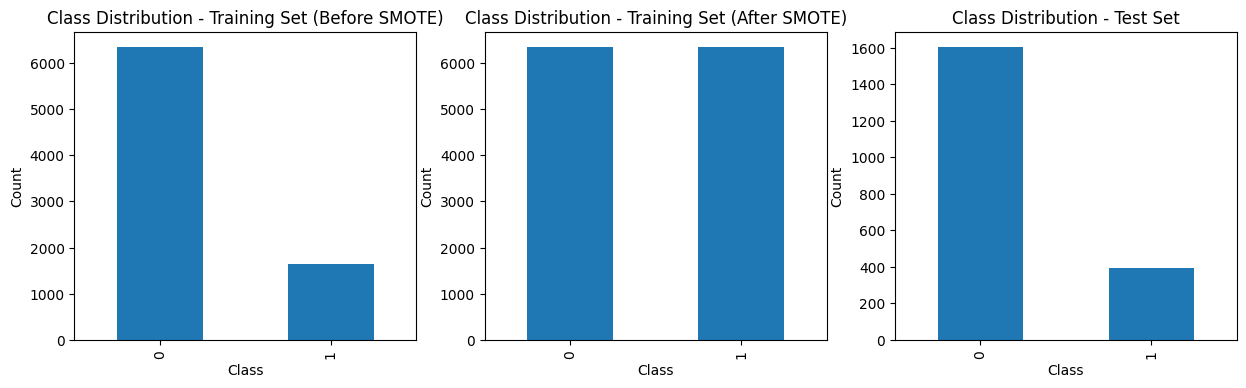

In [51]:
plt.figure(figsize=(15, 4))

# Before SMOTE
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

In [52]:
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/Y_train.npz', Y_train_resampled)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/Y_test.npz', Y_test)